## Compare Velocities for Fastest Configurations

In [1]:
# hom 04,04,04 (225) - 0.331; 04,04,04 (45) - 0.301 
# het 00,16,04 (225) - 0.350; 04,04,04 (45) - 0.307 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation 
import pickle
import sys, os
sys.path.insert(0, os.path.join("..", "source"))
from mass_spring_model import MassSpringModel
from simulation_util import simulation_ensemble, prepare_em_standard, SummaryFunctions

In [2]:
def get_ensemble(filepath, num_units=3, num_nodes=8, has_light_col=False):  # move all this stuff to source code
    ensemble_data = pickle.load(open(filepath,"rb"))
    headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
        f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
        for i in range(num_units)]).flatten().tolist() + np.array([[f"x{i}", f"y{i}"]
        for i in range(num_nodes)]).flatten().tolist() 
    if has_light_col: 
        headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
            f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
            for i in range(num_units)]).flatten().tolist() + ["light_x"] + np.array([[f"x{i}", f"y{i}"]
            for i in range(num_nodes)]).flatten().tolist() 
    return [pd.DataFrame(x, columns=headers) for x in ensemble_data]

def diff(lst, a=np.pi): # successive differences in R/[-a,a] ("else 0" is an approxiamtion)
    return [lst[i]-lst[i-1] if abs(lst[i]-lst[i-1])<a else 0 for i in range(1,len(lst))]

def v_x_angle(df, num_nodes=8, init_angle=5/4 * np.pi, with_light=False):
    sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(num_nodes)]).flatten().tolist()
    df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
    df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
    shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],num_nodes,axis=1)])
    df = df.assign(angle=np.rad2deg((init_angle - np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                                               for v in shifted],axis=0))%(2*np.pi)))
    if with_light: return df[["t","comx","comy","vx","angle","light_x"]]
    return df[["t","comx","comy","vx","angle"]]

def to_avg_bins(df, measurement_times):
    df = df.assign(tidx=np.digitize(df["t"], measurement_times)).groupby("tidx").mean()
    empty = pd.DataFrame(columns=df.columns,index=np.arange(1,len(measurement_times)))
    return pd.concat([df, empty[empty.index.isin(df.index) == False]]).sort_index()

def avg_v_x_angle(ensemble, measurement_times):
    return pd.DataFrame(np.array([to_avg_bins(x, measurement_times).to_numpy() for x in ensemble]).mean(axis=0),
                         columns=["t","comx","comy","vx","angle"])

In [3]:
het225 = [v_x_angle(sim) for sim in get_ensemble("../data/sweeps/18_10_2022/triangle_ds/50sim_3000s_0.00_0.16_0.04ds_225.00ang.p")]
het225avg = avg_v_x_angle(het225,np.linspace(0,3000,11))
het45 = [v_x_angle(sim) for sim in get_ensemble("../data/sweeps/18_10_2022/triangle_ds/50sim_3000s_0.04_0.04_0.01ds_45.00ang.p")]
het45avg = avg_v_x_angle(het45,np.linspace(0,3000,11))
hom45 = [v_x_angle(sim) for sim in get_ensemble("../data/sweeps/27_10_2022/triangle_ds/50sim_3000s_0.04_0.04_0.04ds_45.00ang.p")]
hom45avg = avg_v_x_angle(hom45,np.linspace(0,3000,11))
hom225 = [v_x_angle(sim) for sim in get_ensemble("../data/sweeps/27_10_2022/triangle_ds/50sim_3000s_0.04_0.04_0.04ds_225.00ang.p")]
hom225avg = avg_v_x_angle(hom225,np.linspace(0,3000,11))

In [4]:
[[het225avg["vx"].mean(), het45avg["vx"].mean()], [hom225avg["vx"].mean(), hom45avg["vx"].mean()]]

[[0.000350293961999241, 0.000307432737596765],
 [0.00033199808099910875, 0.00030145921322630447]]

In [5]:
def vln_plt(ensemble,colname,n,xlabel,ylabel,title,ax,ylim=(-0.2,1.0),mul=1000):
    ax.violinplot(np.array([to_avg_bins(sim,np.linspace(0,3000,n+1))[colname].to_numpy()*mul for sim in ensemble]).astype(float),showmeans=True)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.set_xticks(np.arange(1,n+1),labels=(np.arange(1,n+1)*3000/n).astype(int)); ax.set_ylim(*ylim)

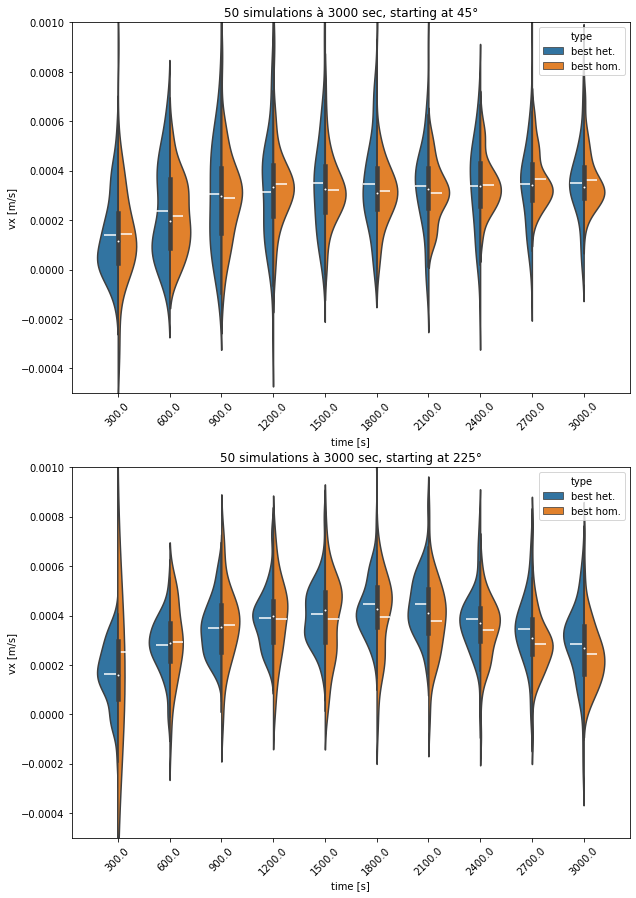

In [18]:
def vln_plt2(het_data,hom_data,xlabel,ylabel,title,ax,colname="vx",n=10,t=3000,ylim=(-0.0005,0.001)): 
    ens = []; means1 = []; means2 = []
    for sim in zip(het_data,hom_data):
        series1 = to_avg_bins(sim[0],np.linspace(0,t,n+1))[colname].astype(float); 
        series2 = to_avg_bins(sim[1],np.linspace(0,t,n+1))[colname].astype(float); 
        ens.append(pd.concat([pd.DataFrame({colname: series1,"idx": series1.index,"type": "best het."}),
                   pd.DataFrame({colname: series2,"idx": series2.index,"type": "best hom."})]))
    df = pd.concat(ens,ignore_index=True)
    sns.violinplot(data=df,x="idx",y=colname,hue="type",split=True,ax=ax)
    ax.set(xlabel=xlabel,ylabel=ylabel,title=title,ylim=ylim)
    ax.set_xticks(np.arange(n),labels=np.arange(1,n+1)*t/n,rotation=45)
    ax.scatter(np.arange(n)-0.15,df[df.type=="best het."].groupby("idx").mean(),marker="_",c="white",s=150)
    ax.scatter(np.arange(n)+0.15,df[df.type=="best hom."].groupby("idx").mean(),marker="_",c="white",s=150)
         
fig, ax = plt.subplots(2,1,figsize=(10,15))
vln_plt2(het45,hom45,"time [s]","vx [m/s]","50 simulations à 3000 sec, starting at 45°",ax[0])
vln_plt2(het225,hom225,"time [s]","vx [m/s]","50 simulations à 3000 sec, starting at 225°",ax[1])
fig.savefig("hom_het_v_ang.jpg",format="jpg",dpi=1200)

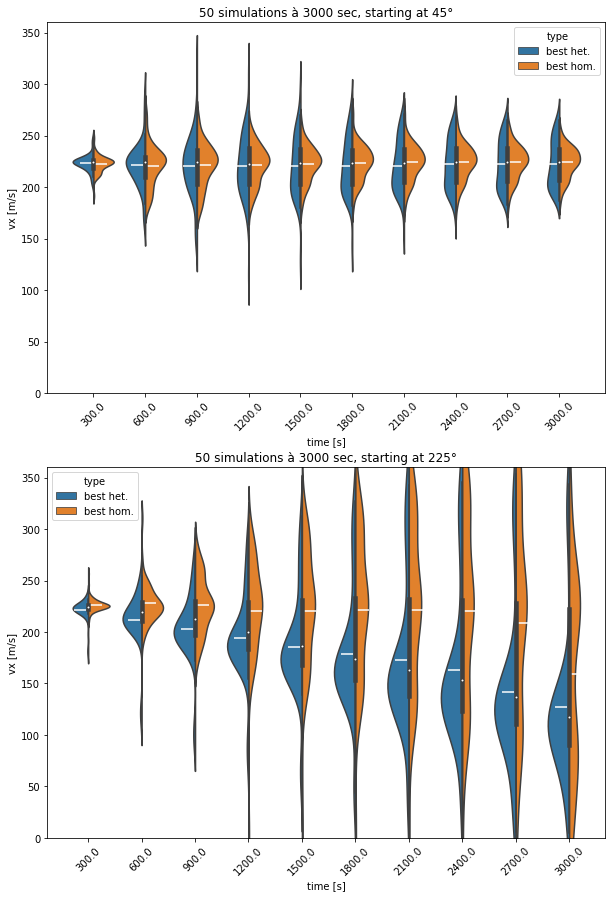

In [30]:
fig, ax = plt.subplots(2,1,figsize=(10,15))
vln_plt2(het45,hom45,"time [s]","vx [m/s]","50 simulations à 3000 sec, starting at 45°",ax[0],colname="angle",ylim=(0,360))
vln_plt2(het225,hom225,"time [s]","vx [m/s]","50 simulations à 3000 sec, starting at 225°",ax[1],colname="angle",ylim=(0,360))
fig.savefig("hom_het_ang_ang.jpg",format="jpg",dpi=1200)

## Compare Adaptability by Changing Light


In [8]:
light_het225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_12000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_225.00ang.p",has_light_col=True)]
light_hom225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_12000s_[1, 1, 1]am_[0.04, 0.04, 0.04]ds_225.00ang.p",has_light_col=True)]

In [9]:
def plt_path(ensemble,ax,title):
    ax.set_title(title); ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
    cmap = colormaps["winter"]; idx = np.linspace(0,1,len(ensemble))
    [ax.scatter(*np.transpose(ensemble[i][["comx","comy"]].to_numpy()),s=0.05,c=ensemble[i]["light_x"]) for i in range(len(ensemble))]

In [58]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib 
from IPython.display import HTML
def animation(position_data, tdata, light_data=[], framerate=10, size=((-0.2,1.2),(-0.5,0.5)),
              elements=[(0, 1), (0, 2), (2, 3), (1, 3), (0, 3), (1, 2), (4, 5), (4, 1), (1, 6), (5, 6), (4, 6), (5, 1), (3, 7), (6, 7), (1, 7), (6, 3)]):
    fig = plt.figure(); #TODO: add time please
    ax = plt.axes(xlim=size[0], ylim=size[1]) 
    ax.set_aspect(1)
    lines = [plt.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    plt.grid(True, linestyle='-.')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, zorder=2)
    def animate(i):
        time_text.set_text('t = %.1fs' % tdata[i * framerate])
        if len(light_data) != 0:
            lgt = "right" if light_data[framerate * i] == 20 else "left"
            time_text.set_text(f"light: {lgt}, " + 't = %.1fs' % tdata[i * framerate])
        U = position_data[i*framerate,-16:]
        for i, el in enumerate(elements): 
            lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])
    ani = FuncAnimation(fig,animate,frames=len(position_data)//framerate)
    return ani
    
    return HTML(ani.to_jshtml())

def draw_configuration(U, ax, elements,size=((-0.2,1.2),(-0.2,0.8)),timetxt=""):
    time_text = ax.text(0.02, 0.95, timetxt,transform=ax.transAxes, zorder=2)
    ax.set(xlim=size[0],ylim=size[1])
    ax.set_aspect(1)
    lines = [ax.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    ax.grid(True, linestyle='-.')
    for i, el in enumerate(elements): 
        lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])

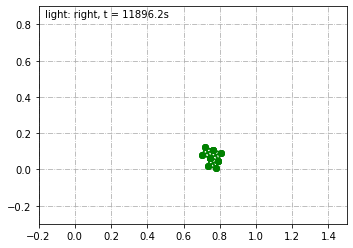

In [60]:
simulation = get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_12000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_225.00ang.p",has_light_col=True)[0]
ani = animation(simulation.to_numpy()[:,-16:],simulation["t"],simulation["light_x"],framerate=100,size=((-0.2,1.5),(-0.3,0.9)))
writer = matplotlib.animation.writers["ffmpeg"](fps=10, bitrate=140)
ani.save("light_switch.mp4", writer=writer)

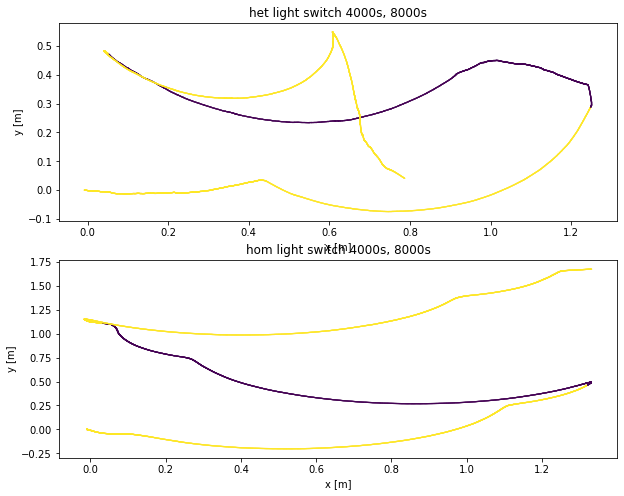

In [10]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
plt_path(light_het225[:1],ax[0],"het light switch 4000s, 8000s")
plt_path(light_hom225[:1],ax[1],"hom light switch 4000s, 8000s")

### Velocity Distributions

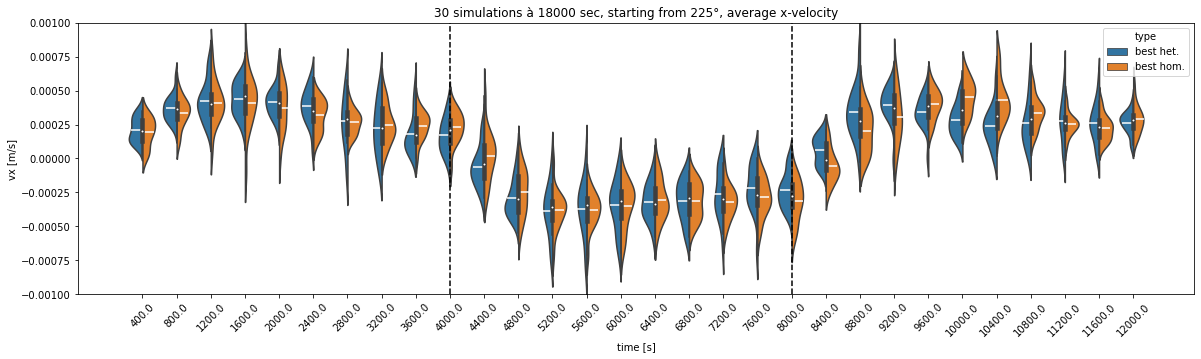

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
bins_hom = [to_avg_bins(x,np.linspace(0,12000,31)) for x in light_hom225]
bins_het = [to_avg_bins(x,np.linspace(0,12000,31)) for x in light_het225]
vln_plt2(bins_het,bins_hom,"time [s]","vx [m/s]","30 simulations à 18000 sec, starting from 225°, average x-velocity",ax,n=30,t=12000,ylim=(-0.001,0.001))
ax.vlines([9,19],-0.001,0.001,colors="black",linestyles="dashed")
fig.savefig("light_switch1.jpg",format="jpg",dpi=1200)

In [12]:
def flatten(lst):  # numpy flatten not compatible with dataframe
    new = []
    for y in range(len(lst)):
        for x in range(len(lst[0])):
            new.append(lst[y][x])
    return new 

def decomp(x):
    return [x.loc[11:20].assign(vx=-x.loc[21:30].vx,t=x.loc[11:20].t-4000).set_index(np.arange(1,11)),
            x.loc[21:30].assign(vx=x.loc[21:30].vx,t=x.loc[21:30].t-2*4000).set_index(np.arange(1,11))]

ValueError: x and y must be the same size

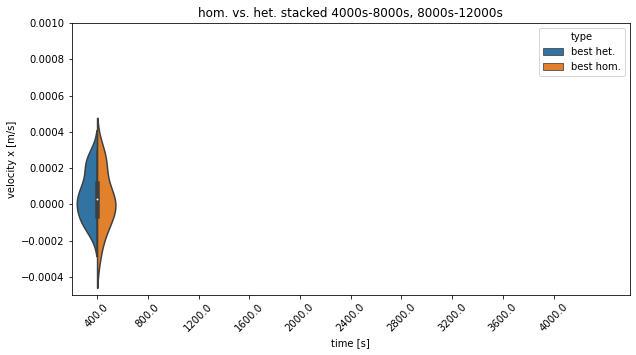

In [71]:
#print(pd.concat(flatten([decomp(x) for x in bins_hom])))
fig, ax = plt.subplots(1,1,figsize=(10,5))
vln_plt2(flatten([decomp(x) for x in bins_het]),flatten([decomp(x) for x in bins_hom]),
        "time [s]","velocity x [m/s]","hom. vs. het. stacked 4000s-8000s, 8000s-12000s",ax,n=10,t=4000)
fig.savefig("stacked_light1.jpg",format="jpg",dpi=1200)

### Angle Distributions 

Text(0, 0.5, 'angle [deg]')

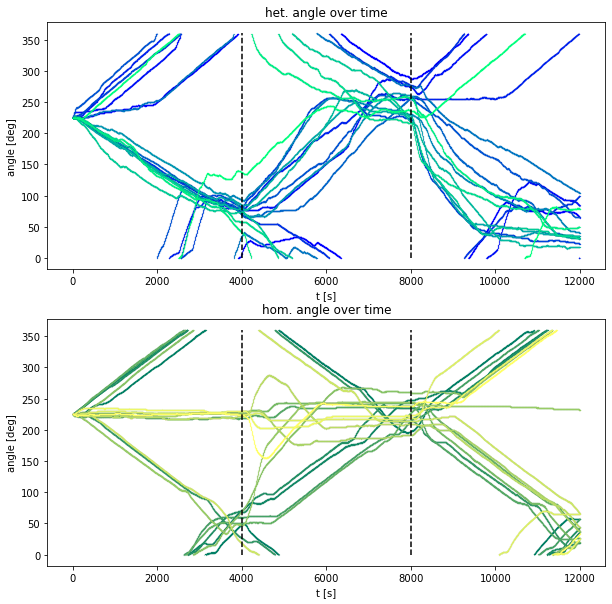

In [54]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
cmap = colormaps["winter"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[0].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_het225)]
ax[0].vlines([4000,8000],0,360,colors="black",linestyles="dashed")
ax[0].set_title("het. angle over time"); ax[0].set_xlabel("t [s]"); ax[0].set_ylabel("angle [deg]")
cmap = colormaps["summer"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[1].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_hom225)]
ax[1].vlines([4000,8000],0,360,colors="black",linestyles="dashed")
ax[1].set_title("hom. angle over time"); ax[1].set_xlabel("t [s]"); ax[1].set_ylabel("angle [deg]")

Text(0.5, 0, 't [s]')

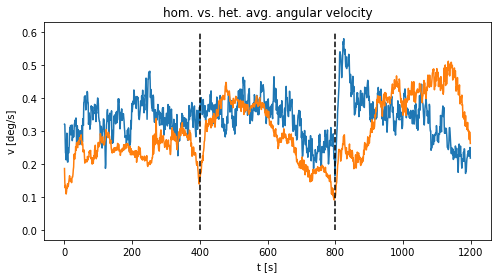

In [257]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.mean([to_avg_bins(x.assign(vang=np.abs(np.diff(np.unwrap(x.angle))).tolist()+[0]), np.linspace(0,12000,1201)).vang
         for x in light_het225],axis=0))
ax.plot(np.mean([to_avg_bins(x.assign(vang=np.abs(np.diff(np.unwrap(x.angle))).tolist()+[0]), np.linspace(0,12000,1201)).vang
         for x in light_hom225],axis=0))
ax.vlines([400,800],0,.6,colors="black",linestyles="dashed")
ax.set_title("hom. vs. het. avg. angular velocity"); ax.set_ylabel("v [deg/10s]"); ax.set_xlabel("t [s]")

### Other Frequencies

In [61]:
light_het225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_8000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_225.00ang.p",has_light_col=True)]
light_hom225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_8000s_[1, 1, 1]am_[0.04, 0.04, 0.04]ds_225.00ang.p",has_light_col=True)]

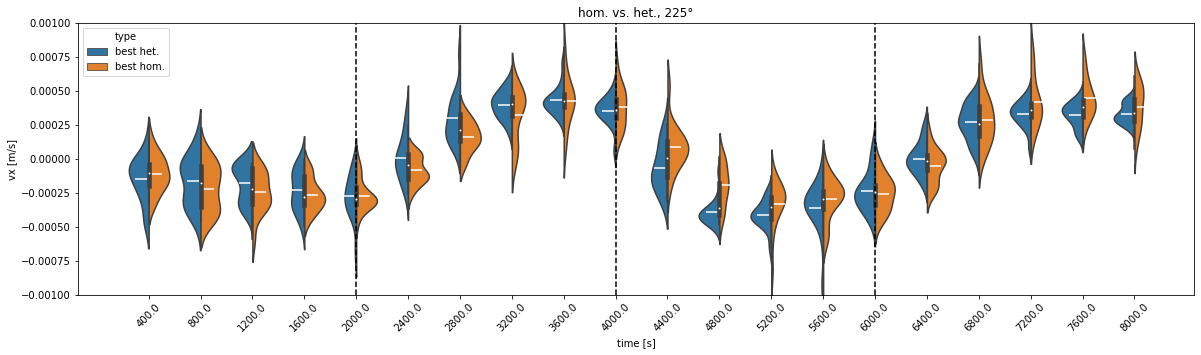

In [63]:
fig, ax = plt.subplots(figsize=(20,5))
bins_hom = [to_avg_bins(x,np.linspace(0,8000,21)) for x in light_hom225]
bins_het = [to_avg_bins(x,np.linspace(0,8000,21)) for x in light_het225]
vln_plt2(bins_het,bins_hom,"time [s]","vx [m/s]","hom. vs. het., 225°",ax,n=20,t=8000,ylim=(-0.001,0.001))
ax.vlines([4,9,14],-0.001,0.001,colors="black",linestyles="dashed")
fig.savefig("light_switch2.jpg",format="jpg",dpi=1200)

Text(0, 0.5, 'angle [deg]')

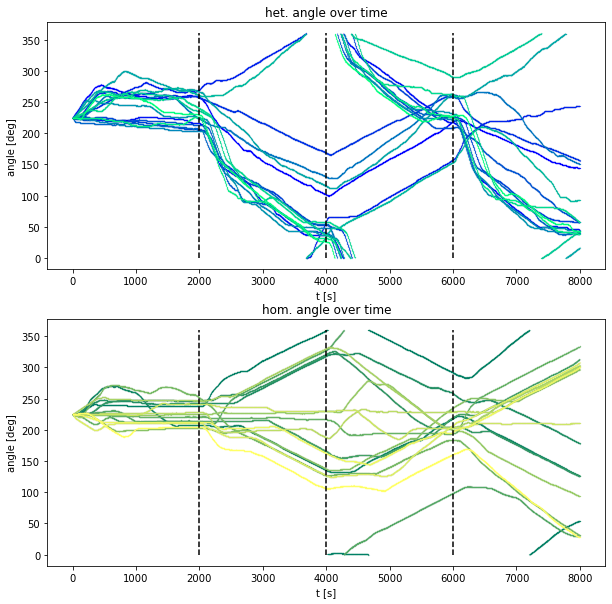

In [287]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
cmap = colormaps["winter"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[0].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_het225)]
ax[0].vlines([2000,4000,6000],0,360,colors="black",linestyles="dashed")
ax[0].set_title("het. angle over time"); ax[0].set_xlabel("t [s]"); ax[0].set_ylabel("angle [deg]")
cmap = colormaps["summer"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[1].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_hom225)]
ax[1].vlines([2000,4000,6000],0,360,colors="black",linestyles="dashed")
ax[1].set_title("hom. angle over time"); ax[1].set_xlabel("t [s]"); ax[1].set_ylabel("angle [deg]")

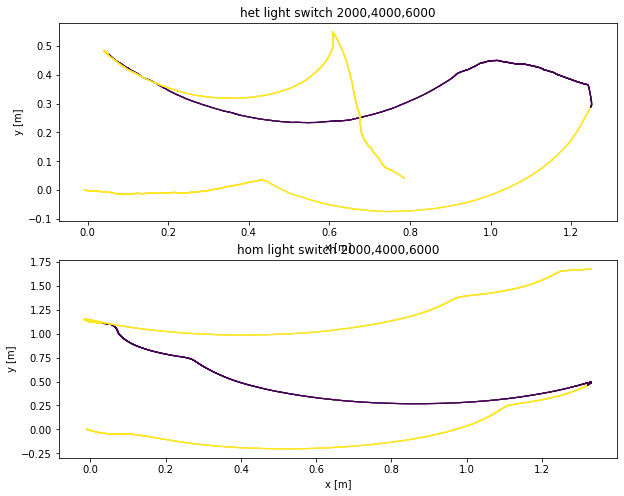

In [23]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
plt_path(light_het225[:1],ax[0],"het light switch 2000,4000,6000")
plt_path(light_hom225[:1],ax[1],"hom light switch 2000,4000,6000")

In [88]:
light_het225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_225.00ang.p",has_light_col=True)]
light_hom225 = [v_x_angle(sim,with_light=True) for sim in get_ensemble("../data/experiment_files/31_10_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.04, 0.04, 0.04]ds_225.00ang.p",has_light_col=True)]

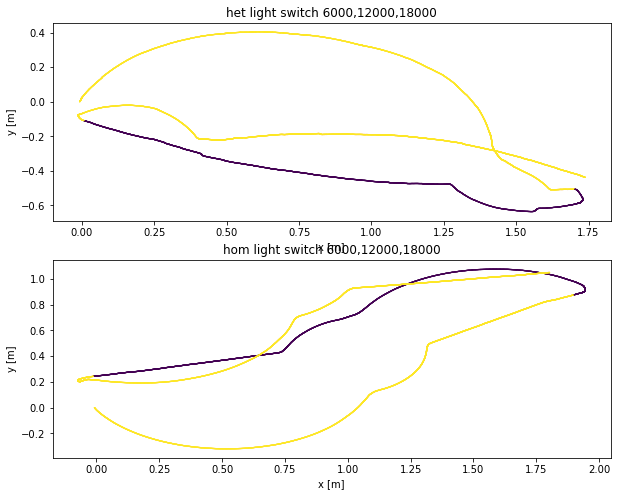

In [89]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
plt_path(light_het225[:1],ax[0],"het light switch 6000,12000,18000")
plt_path(light_hom225[:1],ax[1],"hom light switch 6000,12000,18000")

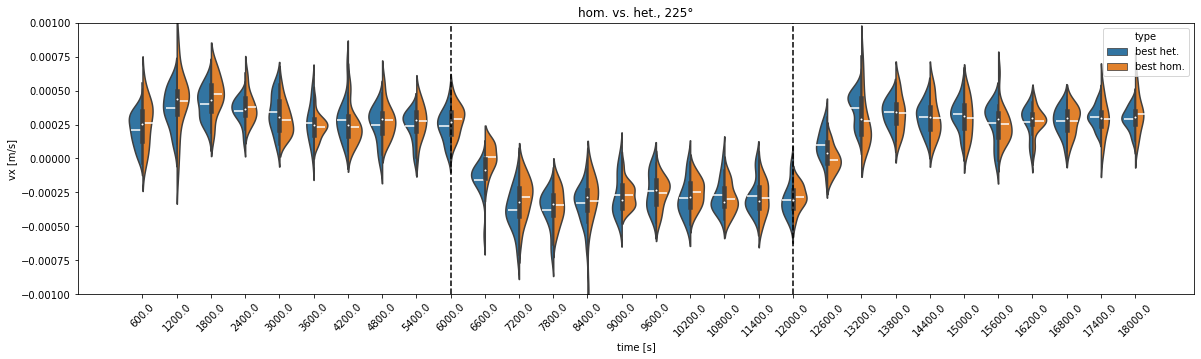

In [90]:
fig, ax = plt.subplots(figsize=(20,5))
bins_hom = [to_avg_bins(x,np.linspace(0,18000,31)) for x in light_hom225]  
bins_het = [to_avg_bins(x,np.linspace(0,18000,31)) for x in light_het225]
vln_plt2(bins_het,bins_hom,"time [s]","vx [m/s]","hom. vs. het., 225°",ax,n=30,t=18000,ylim=(-0.001,0.001))
ax.vlines([9,19],-0.001,0.001,colors="black",linestyles="dashed")
fig.savefig("light_switch_violins1.jpg",format="jpg",dpi=1200)

Text(0, 0.5, 'angle [deg]')

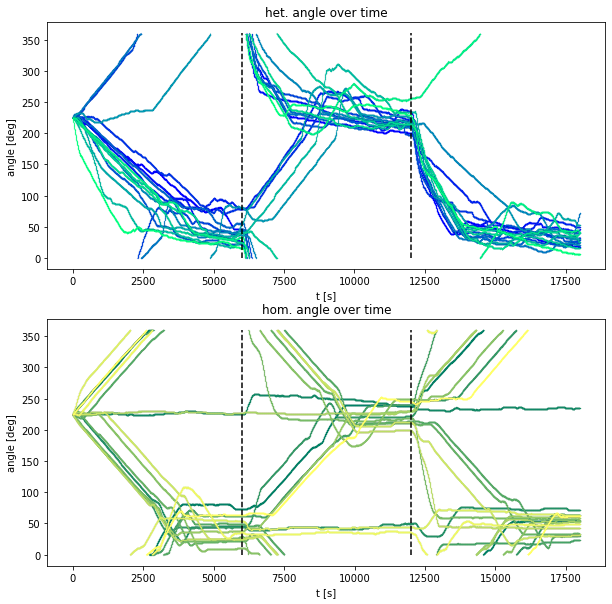

In [23]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
cmap = colormaps["winter"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[0].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_het225)]
ax[0].vlines([6000,12000],0,360,colors="black",linestyles="dashed")
ax[0].set_title("het. angle over time"); ax[0].set_xlabel("t [s]"); ax[0].set_ylabel("angle [deg]")
cmap = colormaps["summer"]; idx = np.linspace(0,1,len(light_het225)); 
[ax[1].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(light_hom225)]
ax[1].vlines([6000,12000],0,360,colors="black",linestyles="dashed")
ax[1].set_title("hom. angle over time"); ax[1].set_xlabel("t [s]"); ax[1].set_ylabel("angle [deg]")

### Rare stable straight lines? (Note: they do not exist in het case!)

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
def colour_path_plt(df,ax):
    cmap = colormaps["hsv"]; idx = np.linspace(0,1,360)[df.angle.astype(int)]
    scat = ax.scatter(df.comx,df.comy,s=0.01,c=cmap(idx))
    switch = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0]
    ax.scatter(df.comx[switch], df.comy[switch],s=100,c='black',marker="*")
    ax.scatter(df.comx[0], df.comy[0],s=100,c='black',marker=">")
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=cmap,norm=Normalize(vmin=0,vmax=360),ticks=np.arange(19)*20).set_label("angle [deg]")

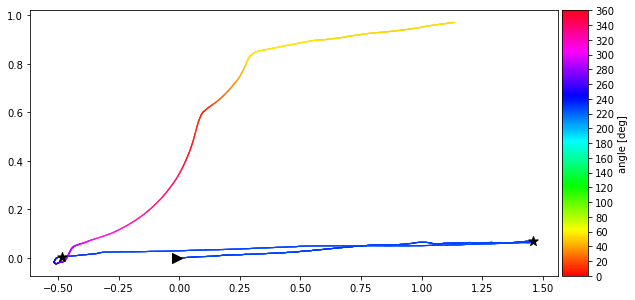

In [177]:
straight_paths = [x for x in light_hom225 if x["angle"][:6000].std() < 5]
fig, ax = plt.subplots(figsize=(10,10)); ax.set_aspect('equal')
colour_path_plt(straight_paths[1],ax)

In [8]:
def animation(position_data, num_nodes=8, elements=[(0, 1), (0, 2), (2, 3), (1, 3), (0, 3), (1, 2), (4, 5), (4, 1), (1, 6), (5, 6), (4, 6), (5, 1), (3, 7), (6, 7), (1, 7), (6, 3)],
              framerate=10, size=((-0.2,1.2),(-0.5,1))):
    fig = plt.figure(); #TODO: add time please
    ax = plt.axes(xlim=size[0], ylim=size[1]) 
    ax.set_aspect(1)
    lines = [plt.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    plt.grid(True, linestyle='-.')
    def animate(i): 
        U = position_data[i*framerate,-num_nodes*2:]
        for i, el in enumerate(elements): 
            lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])
    ani = FuncAnimation(fig,animate,frames=len(position_data)//framerate)
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

## Systematic Frequency Comparison Stacked Plots

In [66]:
hetdf = []; homdf = []      
for suffix in ["[0, 6000, 12000]","4","[0, 3000, 6000, 9000, 12000, 15000]","[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]", "18", "36", "72"]:
    hetdf.append([to_avg_bins(v_x_angle(sim,with_light=True),np.linspace(0,18000,721)) for sim in get_ensemble(f"../data/experiment_files/07_11_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_{suffix}light.p",has_light_col=True)])
    homdf.append([to_avg_bins(v_x_angle(sim,with_light=True),np.linspace(0,18000,721)) for sim in get_ensemble(f"../data/experiment_files/07_11_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.04, 0.04, 0.04]ds_{suffix}light.p",has_light_col=True)])

In [67]:
def light_stack(df,tmax,negate_colnames=["vx","comx"]):
    sidx = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0].tolist() + [len(df.light_x)]
    return [df.loc[sidx[i]+2:sidx[i+1]].assign(**{c : np.power(-1,i+1) * df.loc[sidx[i]+2:sidx[i+1]][c] for c in negate_colnames},
            t=df.loc[sidx[i]+2:sidx[i+1]].t - (i+1)* tmax/len(sidx)).set_index(np.arange(1,sidx[i+1]-sidx[i])) for i in range(len(sidx)-1)]

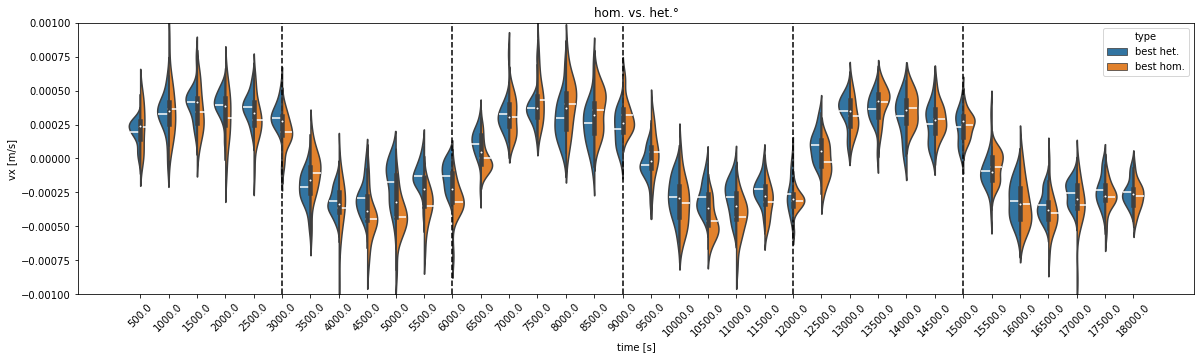

In [98]:
fig, ax = plt.subplots(figsize=(20,5))
bins_hom = [to_avg_bins(x,np.linspace(0,18000,72*4+1))[:] for x in homdf[2]]  
bins_het = [to_avg_bins(x,np.linspace(0,18000,72*4+1))[:] for x in hetdf[2]]
ax.vlines([5,11,17,23,29],-0.001,0.001,color="black",linestyle="dashed")
vln_plt2(bins_het,bins_hom,"time [s]","vx [m/s]","hom. vs. het.°",ax,n=36,t=18000,ylim=(-0.001,0.001))
fig.savefig("violins_freq2_ls.jpg",format="jpg",dpi=1200)

In [69]:
stplst = [6000,4500,3000,2000,1000,500,250]; dfs = []
for i in range(len(stplst)):
    dflst = flatten([[x.vx.mean() for x in light_stack(hetdf[i][j],18000)] for j in range(len(hetdf[i]))])
    dfs.append(pd.DataFrame({"avg_vx": dflst, "step":np.full(len(dflst),stplst[i]), "type": "het"}))
    dflst = flatten([[x.vx.mean() for x in light_stack(homdf[i][j],18000)] for j in range(len(homdf[i]))])
    dfs.append(pd.DataFrame({"avg_vx": dflst, "step":np.full(len(dflst),stplst[i]), "type": "hom"}))

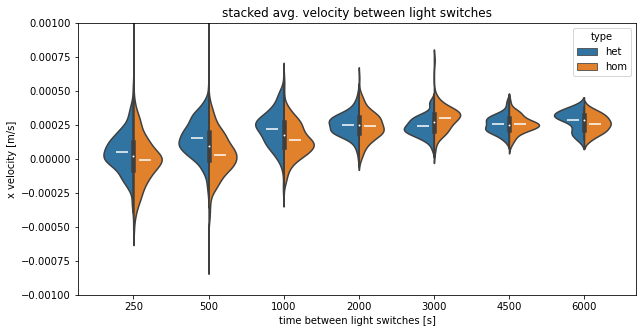

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df = pd.concat(dfs,ignore_index=True)
sns.violinplot(data=df,x="step",y="avg_vx",hue="type",split=True,ax=ax)
ax.set(xlabel="time between light switches [s]",ylabel="x velocity [m/s]",title="stacked avg. velocity between light switches")
ax.set_ylim(-0.001,0.001)
#ax.set_xticks(np.arange(n),labels=np.arange(1,n+1)*t/n,rotation=45)
ax.scatter(np.arange(len(stplst))-0.15,df[df.type=="het"].groupby("step").mean(),marker="_",c="white",s=150)
ax.scatter(np.arange(len(stplst))+0.15,df[df.type=="hom"].groupby("step").mean(),marker="_",c="white",s=150)
fig.savefig("stacked_violins.jpg",format="jpg",dpi=1200)

Middle part: hom dominates because het unstable convergence ?

In [14]:
# plot for each unit acceptance rate over time 
# velocity through phase space (per unit too?)

## Acceptance Rate and Phase Space Velocity Per Unit

In [73]:
hetdf_full = []; homdf_full = []      
for suffix in ["[0, 6000, 12000]","4","[0, 3000, 6000, 9000, 12000, 15000]","[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]", "18", "36", "72"]:
    hetdf_full.append([sim for sim in get_ensemble(f"../data/experiment_files/07_11_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.0, 0.16, 0.04]ds_{suffix}light.p",has_light_col=True)])
    homdf_full.append([sim for sim in get_ensemble(f"../data/experiment_files/07_11_2022/switch_light/16sim_18000s_[1, 1, 1]am_[0.04, 0.04, 0.04]ds_{suffix}light.p",has_light_col=True)])

In [74]:
def where_change(arr):  # indices at which sequence changes value
    return np.where(np.array(arr[1:]) != np.array(arr[:-1]))[0]

In [75]:
def acceptance_rate(df): 
    ar = []
    for i in range(3):
        df2 = df.loc[where_change(df[f"learn cycle {i}"])][-100:]
        ar.append(np.round(len(where_change(df2[f"mem. phi {i}"]))/len(df2[f"mem. phi {i}"]),3))
    return ar
#[[acceptance_rate(sim) for sim in ens] for ens in homdf_full]

[]

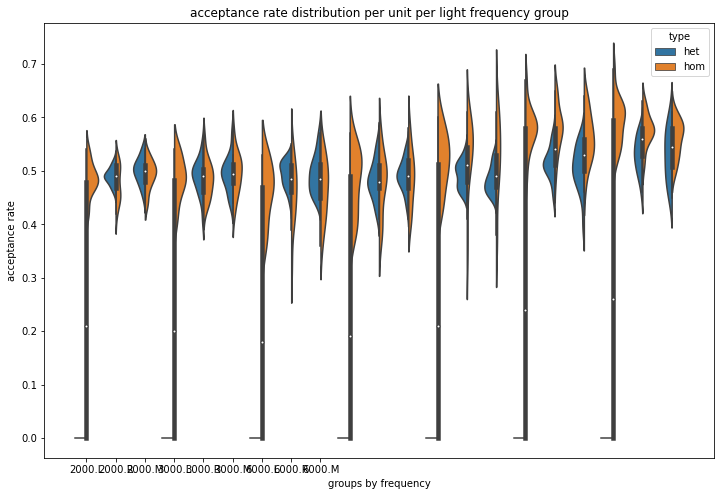

In [76]:
ar_data = pd.concat([pd.concat([pd.DataFrame({"ar":np.array([acceptance_rate(sim) for sim in ens]).reshape((3*len(ens),1)).T[0],
  "x":np.full((len(ens),3),[1.2*i-0.2,1.2*i,1.2*i+0.2]).reshape((3*len(ens),1)).T[0],"type":np.full(3*len(ens),"het")})
 for i, ens in enumerate(hetdf_full)]),
pd.concat([pd.DataFrame({"ar":np.array([acceptance_rate(sim) for sim in ens]).reshape((3*len(ens),1)).T[0],
  "x":np.full((len(ens),3),[1.2*i-0.2,1.2*i,1.2*i+0.2]).reshape((3*len(ens),1)).T[0],"type":np.full(3*len(ens),"hom")})
 for i, ens in enumerate(homdf_full)])],ignore_index=True)
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(data=ar_data,y="ar",x="x",hue="type",split=True,ax=ax).set(xlabel="groups by frequency",
    ylabel="acceptance rate",title="acceptance rate distribution per unit per light frequency group")
ax.set_xticks(np.arange(9),labels=flatten([[f"{i}.{r}" for r in ["L","R","M"]] for i in [2000,3000,6000]]))
plt.plot()

In [77]:
def phase_movement_plt(path,ax,size=1,linewidth=0.1):
    cmap = colormaps["autumn"]; idx = np.linspace(0,1,len(path))
    ax.plot((path["mem. phi 0"]-path["mem. phi 2"])%2,
               (path["mem. phi 1"]-path["mem. phi 2"])%2,lw=linewidth,c="black")
    ax.scatter((path["mem. phi 0"]-path["mem. phi 2"])%2,
               (path["mem. phi 1"]-path["mem. phi 2"])%2,s=size,c=cmap(idx))
    ax.set(xlabel="phi left - phi middle",ylabel="phi right - phi middle", title="movement through phase space",aspect=1)
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect(1)
    ColorbarBase(cax,cmap=cmap,norm=Normalize(vmin=0,vmax=18000),ticks=np.arange(18)*1000).set_label("t [s]")

In [78]:
def phase_space_path(df,bins): 
    p = to_avg_bins(df[1:],bins)[[f"mem. phi {i}" for i in range(3)]].assign(t=bins[:-1]).astype(float)
    return p[~p["mem. phi 0"].isnull()]

def phase_space_speed(path,dt=2.0):
    p = np.apply_along_axis(lambda x: np.unwrap(x,period=2),0,path.to_numpy()[:,:-1])
    return [0] + [np.linalg.norm(p[i] - p[i-1])/dt for i in range(1,len(p))]

def avg_ps_speed(sim,bins=np.linspace(0,18000,9001)):
    return np.mean(phase_space_speed(phase_space_path(sim,bins)))

def moving_average_speed(vec,n=10,dt=2.0):
    pnts = []
    for a in vec:
        pnts.append(np.convolve(np.unwrap(a,period=2), np.ones(n)/n, mode='valid'))
    pnts = np.transpose(pnts)
    return [0] + [np.linalg.norm(pnts[i] - pnts[i-1])/dt for i in range(1,len(pnts))]

In [85]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from matplotlib import colormaps

def hom_het_path_comparison(ax,phase_path1, phase_path2, bins,line=False,s=1,dt=2.0,binsteps=[]): #het first
    if line: [ax[0,0].plot(phase_path1["t"],phase_path1[f"mem. phi {i}"]) for i in range(3)]
    else: [ax[0,0].scatter(phase_path1["t"],phase_path1[f"mem. phi {i}"],s=1) for i in range(3)]
    ax[0,0].set(xlabel="time [s]",ylabel="phase [s]",title="het. phase per unit")
    ax[0,0].vlines(binsteps,0,2,colors="black",linestyles="dashed")
    ax[1,0].plot(phase_path1["t"],phase_space_speed(phase_path1))
    ax[1,0].set(xlabel="time [s]",ylabel="speed",title="het. speed in phase space")
    ax[1,0].vlines(binsteps,0,1,colors="black",linestyles="dashed")
    phase_movement_plt(to_avg_bins(phase_path1,bins),ax[2,0],s,0)  
    ax[2,0].set(title="hom. movement through phase space")
    if line: [ax[0,1].plot(phase_path2["t"],phase_path2[f"mem. phi {i}"]) for i in range(3)] 
    else: [ax[0,1].scatter(phase_path2["t"],phase_path2[f"mem. phi {i}"],s=1) for i in range(3)]
    ax[0,1].set(xlabel="time [s]",ylabel="phase [s]",title="hom. phase per unit")
    ax[0,1].vlines(binsteps,0,2,colors="black",linestyles="dashed")
    ax[1,1].plot(phase_path2["t"],phase_space_speed(phase_path2))
    ax[1,1].set(xlabel="time [s]",ylabel="speed",title="hom. speed in phase space")
    ax[1,1].vlines(binsteps,0,1,colors="black",linestyles="dashed")
    phase_movement_plt(to_avg_bins(phase_path2,bins),ax[2,1],s,0)  
    ax[2,1].set(title="hom. movement through phase space")
    ax[3,0].plot(moving_average_speed(phase_path1[[f"mem. phi {i}" for i in range(3)]].to_numpy().T,100))
    ax[3,1].plot(moving_average_speed(phase_path2[[f"mem. phi {i}" for i in range(3)]].to_numpy().T,100))

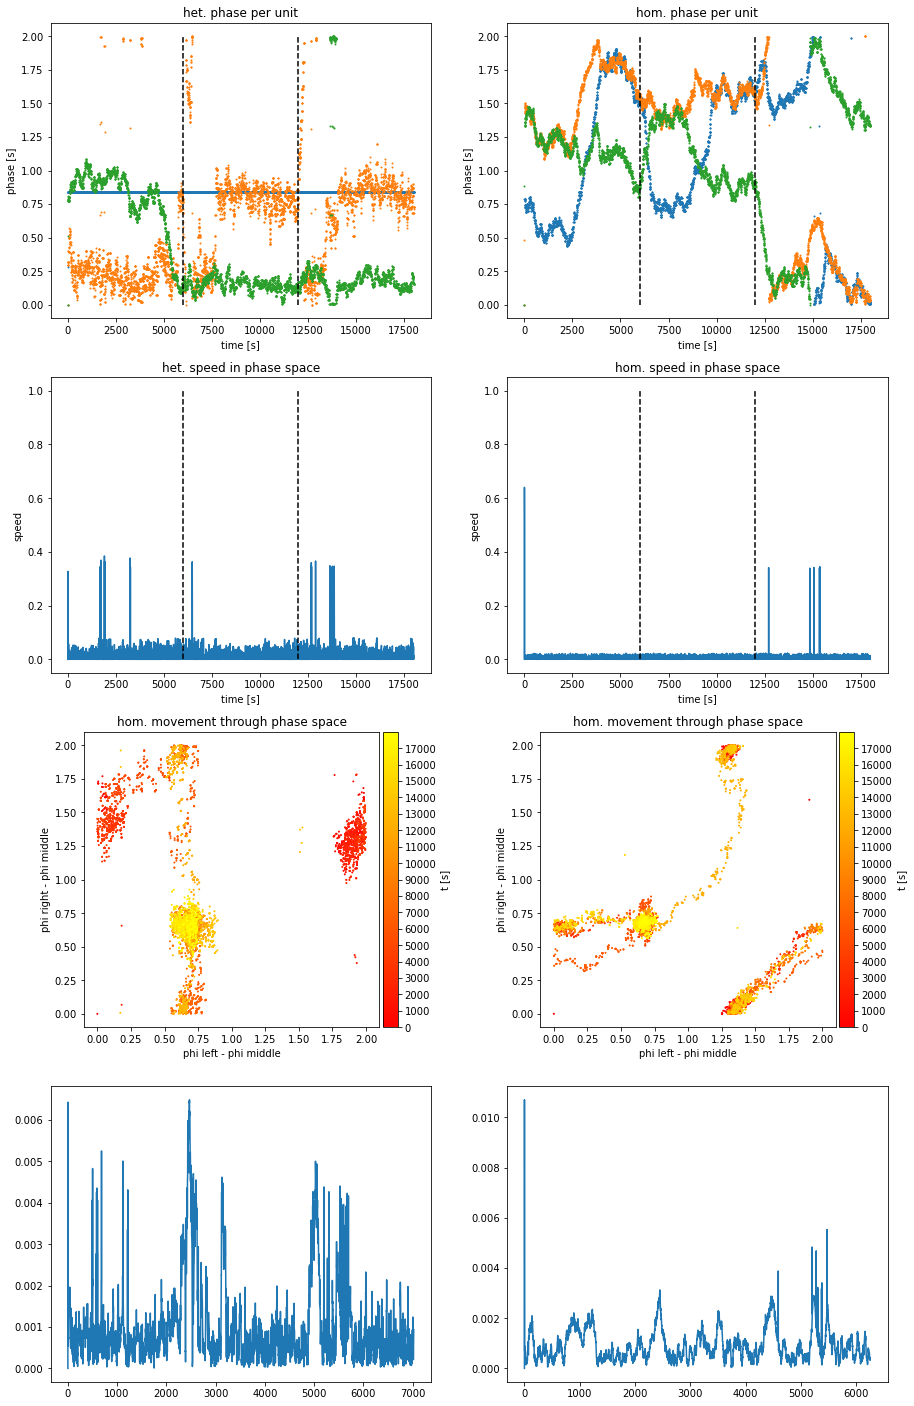

In [99]:
fig, ax = plt.subplots(4,2,figsize=(15,25))
hom_het_path_comparison(ax,phase_space_path(hetdf_full[0][0],np.linspace(0,18000,9001)),
                        phase_space_path(homdf_full[0][0],np.linspace(0,18000,9001)), 
                        np.linspace(0,18000,9001),binsteps=np.arange(0,18000,stplst[0])[1:])
fig.savefig("phase_speed.jpg",format="jpg",dpi=1200)

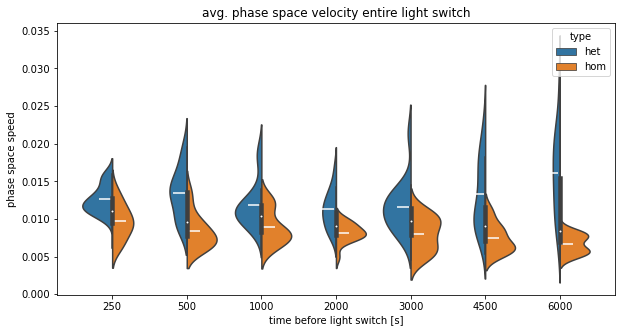

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = pd.concat([
    pd.DataFrame({"v":flatten([[avg_ps_speed(sim) for sim in ens] for ens in hetdf_full]), 
                  "step":np.full((len(hetdf_full[0]),len(stplst)),stplst).T.flatten(),"type":np.full(len(hetdf_full[0])*len(stplst),"het")}),
    pd.DataFrame({"v":flatten([[avg_ps_speed(sim) for sim in ens] for ens in homdf_full]), 
                  "step":np.full((len(homdf_full[0]),len(stplst)),stplst).T.flatten(),"type":np.full(len(homdf_full[0])*len(stplst),"hom")})
    ])
sns.violinplot(data=dat,x="step",y="v",hue="type",split=True,ax=ax)
ax.set(xlabel="time before light switch [s]",ylabel="phase space speed",title="avg. phase space velocity entire light switch")
#ax.set_xticks(np.arange(n),labels=np.arange(1,n+1)*t/n,rotation=45)
ax.scatter(np.arange(len(stplst))-0.1,dat[dat.type=="het"].groupby("step").mean(),marker="_",c="white",s=150)
ax.scatter(np.arange(len(stplst))+0.1,dat[dat.type=="hom"].groupby("step").mean(),marker="_",c="white",s=150)
fig.savefig("phase_speed_ls1.jpg",format="jpg",dpi=1200)

In [ ]:
[[x["mem. phi 0"] for x in ens] for ens in homdf_full][0]

In [189]:
psvd1 = [([np.mean([avg_ps_speed(part) for part in light_stack(to_avg_bins(sim,np.linspace(0,18000,721)),18000,negate_colnames=[])]) for sim in ens[:]],18000/stplst[i] - 1) for i, ens in enumerate(hetdf_full[:])]
psvd2 = [([np.mean([avg_ps_speed(part) for part in light_stack(to_avg_bins(sim,np.linspace(0,18000,721)),18000,negate_colnames=[])]) for sim in ens[:]],18000/stplst[i] - 1) for i, ens in enumerate(homdf_full[:])]

KeyError: "None of [Index(['mem. phi 0', 'mem. phi 1', 'mem. phi 2'], dtype='object')] are in the [columns]"

In [ ]:
psvd2

In [172]:
avg_ps_speed(light_stack(to_avg_bins(hetdf_full[-1][0],np.linspace(0,18000,721)),18000,negate_colnames=[])[0])

0.1326322636273306

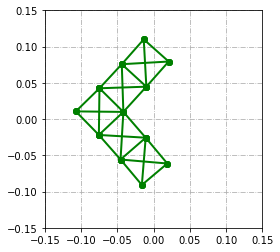

In [33]:
animation(get_ensemble("../data/experiment_files/09_11_2022/switch_light/1sim_14s_[0, 10, 0, 10, 10]am_[0.04 0.04 0.04 0.04 0.04]ds_[0, 7000]light.p",
                       has_light_col=True,num_units=5,num_nodes=12)[0].to_numpy()[:,-24:],framerate=1,num_nodes=12,size=((-.15,.15),(-.15,.15)),
         elements=[[0, 1], [0, 2], [2, 3], [1, 3], [0, 3], [1, 2], [1, 4], [3, 5], [4, 5], [1, 5], [4, 3], [6, 7], [6, 8], [8, 9], [7, 9], [6, 9], [7, 8], [8, 4], [4, 10], [9, 10], [8, 10], [9, 4], [5, 11], [10, 11], [4, 11], [10, 5]])